In [1]:
import pyarrow.orc as orc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import optuna
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Define the file path
path = r'C:/BigData/ProjectStaging/dataExport/fraud_mart_final.orc'

# 2. Load the file using PyArrow
orc_file = orc.ORCFile(path)

# 3. Read the table and slice it immediately to 16M rows
# table.slice(offset, length) is memory efficient
table = orc_file.read().slice(0, 16000000)

# 4. Convert to Pandas with "self_destruct" to keep memory footprint low
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Prevents needing one single massive contiguous block of RAM
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(f"Successfully loaded {len(df):,} rows.")
print(df.head())
print(df.info()) # Check memory usage

Successfully loaded 16,000,000 rows.
    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63  

In [4]:
print("Step 1: extracting timestamps and sorting...")

import gc

# 1. Extract Unix Timestamp from transaction_id (Format: User-Card-Timestamp)
# taking the last part of the string '61-5-1514771820' -> '1514771820'
df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)

# 2. Convert to Datetime object
df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 3. Sort by Time (Oldest -> Newest) to respect Time Series nature
df.sort_values('datetime', inplace = True)

# 4. Reset index IN-PLACE
df.reset_index(drop=True, inplace=True)

gc.collect()

df.head(5)

Step 1: extracting timestamps and sorting...


,transaction_id,user_id,card,merchant_id,label_is_fraud,amount,hour_of_day,use_chip,merchant_category,error_code,credit_utilization,state_mismatch,current_age,yearly_income_person,fico_score,card_type,card_brand,unix_time,datetime
0,791-1-662780400,791,1,2027553650310142703,0,68.00,7,Swipe,5541,N/A,0.002006,0,58,72510.00,727,Credit,Amex,662780400,1991-01-02 01:40:00
1,791-1-662780820,791,1,2027553650310142703,0,-68.00,7,Swipe,5541,N/A,-0.002006,0,58,72510.00,727,Credit,Amex,662780820,1991-01-02 01:47:00
2,791-1-662781060,791,1,2027553650310142703,0,113.62,7,Swipe,5541,N/A,0.003352,0,58,72510.00,727,Credit,Amex,662781060,1991-01-02 01:51:00
3,791-1-662817600,791,1,-7269691894846892021,0,114.73,17,Swipe,5411,N/A,0.003384,0,58,72510.00,727,Credit,Amex,662817600,1991-01-02 12:00:00
4,791-1-662873580,791,1,-3693650930986299431,0,251.71,9,Swipe,4814,N/A,0.007425,0,58,72510.00,727,Credit,Amex,662873580,1991-01-03 03:33:00


In [5]:
print("Step 2: Memory-Surgical Feature Engineering...")

# 1. Convert Decimal 'amount' to float32 immediately
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').astype(np.float32)

# 2. Convert Objects (Strings) to Categories
for col in ['use_chip', 'card_type', 'error_code', 'merchant_category']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Extract Time Components & Cyclical Encoding
df['hour_of_day'] = df['datetime'].dt.hour.astype(np.int8)
df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df.drop(columns=['hour_of_day', 'day_of_week'], inplace=True)
gc.collect()

# 4. FIXED: Memory-Surgical 'trans_last_24h' (Velocity)
print("Calculating Velocity (trans_last_24h) using NumPy...")
df.sort_values(['user_id', 'unix_time'], inplace=True)

user_ids = df['user_id'].values
unix_times = df['unix_time'].values
velocity_counts = np.zeros(len(df), dtype=np.int16)

# Find where each user's data starts and ends
user_changes = np.where(user_ids[:-1] != user_ids[1:])[0] + 1
user_starts = np.insert(user_changes, 0, 0)
user_ends = np.append(user_changes, len(df))

# Loop over each user (Efficient because it doesn't copy the DF)
for start, end in zip(user_starts, user_ends):
    user_time_window = unix_times[start:end]
    # For every transaction, find how many happened in the previous 86400 seconds
    # searchsorted is extremely fast (logarithmic time)
    lookback_indices = np.searchsorted(user_time_window, user_time_window - 86400, side='left')
    velocity_counts[start:end] = (np.arange(len(user_time_window)) - lookback_indices + 1).astype(np.int16)

df['trans_last_24h'] = velocity_counts
del user_ids, unix_times, velocity_counts, user_starts, user_ends, user_changes
gc.collect()

# 5. Time Since Last Transaction (Speed)
df['time_since_last_trans'] = df['unix_time'].diff().fillna(0).astype(np.float32)
user_changed = df['user_id'] != df['user_id'].shift(1)
df.loc[user_changed, 'time_since_last_trans'] = 0
del user_changed
gc.collect()

# 6. Amount Behavioral Features
print("Calculating user behavioral stats...")
user_medians = df.groupby('user_id')['amount'].transform('median').astype(np.float32)
df['diff_from_median'] = (df['amount'] - user_medians).astype(np.float32)
df['amount_ratio'] = (df['amount'] / (user_medians + 1)).astype(np.float32)
del user_medians
gc.collect()

# 7. Final Projection to save memory
cols_to_keep = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 
    'hour_cos', 'day_sin', 'day_cos', 'diff_from_median', 'amount_ratio',
    'trans_last_24h', 'use_chip', 'card_type', 'error_code', 'merchant_category', 
    'label_is_fraud', 'unix_time'
]
df = df[cols_to_keep]
gc.collect()

print("Step 2 Finished successfully with zero memory leaks.")

Step 2: Memory-Surgical Feature Engineering...
Calculating Velocity (trans_last_24h) using NumPy...
Calculating user behavioral stats...
Step 2 Finished successfully with zero memory leaks.


In [6]:
print("Step 3: Preparing Data for Splitting...")

# 1. Recover 'datetime' if it was dropped during memory optimization
if 'datetime' not in df.columns and 'unix_time' in df.columns:
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 2. Global Temporal Sort (Ensures Test = Future transactions)
# We sort by unix_time as it's faster than sorting by datetime objects
df.sort_values('unix_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Define Temporal Split (80% Train, 10% Val, 10% Test)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Print timing info to verify the split is chronological
print(f"--- Temporal Split Verification ---")
print(f"Train Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val   Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

# 4. Target Encoding for Merchant Category (Crucial: Use ONLY Training labels)
print("\nTarget encoding merchant_category...")
mcc_map = train_df.groupby('merchant_category')['label_is_fraud'].mean()
global_mean = train_df['label_is_fraud'].mean()

# Map the fraud risk scores and convert to float32 for memory efficiency
for d in [train_df, val_df, test_df]:
    d['mcc_risk'] = d['merchant_category'].map(mcc_map).fillna(global_mean).astype(np.float32)

# 5. Feature Selection
numeric_features = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch',
    'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'mcc_risk', 'diff_from_median'
]
categorical_features = ['use_chip', 'card_type', 'error_code']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['label_is_fraud']

X_val = val_df[numeric_features + categorical_features]
y_val = val_df['label_is_fraud']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['label_is_fraud']

# 6. Final Memory Clean up: Delete the original massive dataframe
del df
gc.collect()

print("\nStep 3 Complete. Train, Val, and Test sets are ready.")

Step 3: Preparing Data for Splitting...
--- Temporal Split Verification ---
Train Period: 1991-01-02 01:40:00 to 2017-04-17 04:45:00
Val   Period: 2017-04-17 04:46:00 to 2018-09-26 14:24:00
Test  Period: 2018-09-26 14:24:00 to 2020-02-28 18:28:00

Target encoding merchant_category...

Step 3 Complete. Train, Val, and Test sets are ready.


In [7]:
# Robustly convert all features to numeric for LGBM
for d in [X_train, X_val, X_test]:
    # 1. Fix 'yearly_income_person' (Object -> Float)
    if 'yearly_income_person' in d.columns:
        d['yearly_income_person'] = pd.to_numeric(d['yearly_income_person'], errors='coerce').astype(np.float32)
    
    # 2. Fix Categorical Features (Object/Category -> Integer Codes)
    for col in categorical_features:
        if col in d.columns:
            # Explicitly cast to category first to avoid AttributeError, then get codes
            d[col] = d[col].astype('category').cat.codes.astype(np.int32)

print("Check dtypes - All should now be int or float:")
print(X_train[categorical_features + ['yearly_income_person']].dtypes)

Check dtypes - All should now be int or float:
use_chip                  int32
card_type                 int32
error_code                int32
yearly_income_person    float32
dtype: object


In [9]:
print(" Applying Master Scaling...")

# 1. Initialize the Master Scaler
# We fit this ONCE on X_train and reuse it everywhere.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

if 'X_test' in locals():
    X_test = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val= pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

 Applying Master Scaling...


In [10]:
# --- CELL 1: AUTOENCODER FEATURE ENGINEERING ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

print("🚀 Starting Autoencoder Training for Feature Engineering...")

# 1. Prepare Data for Autoencoder
# We train ONLY on non-fraud (class 0) to learn the "Normal" pattern perfectly.
X_train_normal = X_train[y_train == 0]

# 2. Define Architecture
input_dim = X_train.shape[1]
encoding_dim = 16  # Bottleneck layer

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder) # Bottleneck
decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder) # Reconstruct

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# 3. Train
# We use EarlyStopping to prevent wasting time
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("   Training Autoencoder on 'Normal' transactions...")
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# 4. Generate the "Reconstruction Error" Feature
# High error = The model couldn't reconstruct it = It's likely Fraud
def get_recon_error(model, data):
    reconstructions = model.predict(data, verbose=0)
    mse = np.mean(np.power(data - reconstructions, 2), axis=1)
    return mse

🚀 Starting Autoencoder Training for Feature Engineering...
   Training Autoencoder on 'Normal' transactions...
Epoch 1/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step - loss: 0.0288 - val_loss: 0.0028
Epoch 2/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0086 - val_loss: 0.0038
Epoch 3/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - loss: 0.0074 - val_loss: 0.0019
Epoch 4/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 5/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 6/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 7/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 9/20
44946/44946 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - loss: 0.0048 - val_loss: 0.0022
   Generating 'autoencoder_error' feature...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [12]:
print("   Generating 'autoencoder_error' feature...")
# Add this new feature to your datasets
X_train['autoencoder_error'] = get_recon_error(autoencoder, X_train_scaled)
X_val['autoencoder_error']   = get_recon_error(autoencoder, X_val_scaled)

print("Autoencoder Feature Added. Ready for Stacking.")

   Generating 'autoencoder_error' feature...
Autoencoder Feature Added. Ready for Stacking.


In [19]:
# 1. Get the actual width of X_test
n_cols = X_test.shape[1] 

# 2. Grab exactly that many column names from X_train
# (We assume the original features are the first N columns)
correct_cols = X_train.columns[:n_cols]

print(f"   - X_test has {n_cols} columns")
print(f"   - Assigning headers: {list(correct_cols)}")

# 3. Create DataFrame safely
X_test = pd.DataFrame(X_test, columns=correct_cols)

# 4. Now Scale & Add the Feature
# We use the existing scaler (which expects these 18 columns)
X_test_scaled = scaler.transform(X_test)
X_test['autoencoder_error'] = get_recon_error(autoencoder, X_test_scaled)

print(f"Success! X_test shape is now: {X_test.shape}")

   - X_test has 18 columns
   - Assigning headers: ['amount', 'credit_utilization', 'current_age', 'yearly_income_person', 'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'mcc_risk', 'diff_from_median', 'use_chip', 'card_type', 'error_code']
Success! X_test shape is now: (1600000, 19)


In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import gc

print("--- Optimizing Isolation Forest Feature ---")

# 1. Create a manageable subsample for Optuna
# IF is slow. We optimize on 100k rows to be fast.
# We include ALL fraud in this sample to ensure the metric is valid.
X_opt_fraud = X_train[y_train == 1]
X_opt_normal = X_train[y_train == 0].sample(n=100000, random_state=42)
X_opt = pd.concat([X_opt_fraud, X_opt_normal])
y_opt = pd.concat([y_train[X_opt_fraud.index], y_train[X_opt_normal.index]])

def objective_iso(trial):
    # Search Space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    
    # Train Model
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_opt)
    
    # Predict (Lower score = More Anomalous)
    # We invert the score (-) so that Higher = More Suspicious for AUC calculation
    scores = -clf.decision_function(X_opt)
    
    # Maximize correlation with actual fraud
    auc = average_precision_score(y_opt, scores)
    return auc

study_iso = optuna.create_study(direction='maximize')
study_iso.optimize(objective_iso, n_trials=10) # 15 trials is enough for this

print("Best IF Params:", study_iso.best_params)
best_iso_params = study_iso.best_params

# Clean up memory
del X_opt, X_opt_fraud, X_opt_normal, y_opt
gc.collect()

--- Optimizing Isolation Forest Feature ---


[I 2026-01-25 16:01:41,130] A new study created in memory with name: no-name-829f11b7-b012-4f90-8fec-c897225c1535
[I 2026-01-25 16:01:43,956] Trial 0 finished with value: 0.26344644980493304 and parameters: {'n_estimators': 66, 'max_samples': 0.8125062965310227, 'max_features': 0.5484090909425807}. Best is trial 0 with value: 0.26344644980493304.
[I 2026-01-25 16:01:49,093] Trial 1 finished with value: 0.27398855266603506 and parameters: {'n_estimators': 128, 'max_samples': 0.9455291560831847, 'max_features': 0.7180965226722944}. Best is trial 1 with value: 0.27398855266603506.
[I 2026-01-25 16:01:51,620] Trial 2 finished with value: 0.26608063600280063 and parameters: {'n_estimators': 61, 'max_samples': 0.9436109752758156, 'max_features': 0.7261288915236701}. Best is trial 1 with value: 0.27398855266603506.
[I 2026-01-25 16:01:58,621] Trial 3 finished with value: 0.2637636676374357 and parameters: {'n_estimators': 187, 'max_samples': 0.5899228353021173, 'max_features': 0.5745033766758

Best IF Params: {'n_estimators': 134, 'max_samples': 0.9585016917952498, 'max_features': 0.5066716039588172}


37991

In [22]:
print("--- STAGE 0: Generating Scores & Filtering ---")

# 1. Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=best_iso_params['n_estimators'],
    # Safety: If Optuna picked a float (percentage), cap it to avoid RAM crash
    max_samples=best_iso_params['max_samples'],
    max_features=best_iso_params['max_features'],
    n_jobs=-1, 
    random_state=42
)

# 2. FIT on a Subset
# We do not need to fit on 100% of rows to learn what "Normal" is.
X_fit_iso = X_train.sample(n=500000, random_state=42)
iso_forest.fit(X_fit_iso)
del X_fit_iso # Free memory immediately

# 3. SCORE the Full Datasets
# This attaches the 'anomaly_score' column to everyone
print("Scoring X_train...")
X_train['anomaly_score'] = -iso_forest.decision_function(X_train)

print("Scoring X_val & X_test...")
X_val['anomaly_score'] = -iso_forest.decision_function(X_val)
X_test['anomaly_score'] = -iso_forest.decision_function(X_test)

--- STAGE 0: Generating Scores & Filtering ---
Scoring X_train...
Scoring X_val & X_test...


In [23]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("--- Generating Advanced Unsupervised Features (Clustering & PCA) ---")

# 1. Select Key Numerical Columns
# We use the behavioral features, as these define the "Shape of Fraud"
enrich_cols = [
    'amount', 
    'anomaly_score',
    'credit_utilization', 
    'current_age', 
    'yearly_income_person', 
    'fico_score', 
    'trans_last_24h', 
    'amount_ratio', 
    'time_since_last_trans', 
    'diff_from_median'
]

# Safety Check: Ensure these columns exist in X_train
available_cols = [c for c in enrich_cols if c in X_train.columns]
if len(available_cols) < len(enrich_cols):
    print(f"Warning: Some columns missing. Using: {available_cols}")
    enrich_cols = available_cols

print(f"Using {len(enrich_cols)} features for unsupervised enrichment...")

# 2. Internal Scaling (Crucial for KMeans/PCA)
# We use a separate scaler so we don't disturb the main dataset
enrich_scaler = StandardScaler()

# Fit on Train, Transform on all
X_scaled_train = enrich_scaler.fit_transform(X_train[enrich_cols])
X_scaled_val = enrich_scaler.transform(X_val[enrich_cols])
X_scaled_test = enrich_scaler.transform(X_test[enrich_cols])

--- Generating Advanced Unsupervised Features (Clustering & PCA) ---
Using 10 features for unsupervised enrichment...


In [24]:
# --- FEATURE A: Cluster Distance (MiniBatchKMeans) ---
print("1. Computing Cluster Distances...")
# We fit only on NORMAL data (y=0) to learn "Normal Prototypes"
# We increase clusters to 30 to capture the complexity of features
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=4096, random_state=42)
normal_mask = (y_train == 0)

kmeans.fit(X_scaled_train[normal_mask])

def get_cluster_dist(X_scaled, model):
    # Calculate Euclidean distance to the nearest normal cluster center
    dist_matrix = model.transform(X_scaled)
    return np.min(dist_matrix, axis=1)

X_train['enriched_cluster_dist'] = get_cluster_dist(X_scaled_train, kmeans)
X_val['enriched_cluster_dist'] = get_cluster_dist(X_scaled_val, kmeans)
X_test['enriched_cluster_dist'] = get_cluster_dist(X_scaled_test, kmeans)


1. Computing Cluster Distances...


In [25]:
# --- FEATURE B: PCA Reconstruction Error ---
print("2. Computing PCA Reconstruction Error...")
# We compress 9+ dimensions down to 3, then try to reconstruct.
# Fraud (which breaks the correlation rules of normal behavior) will have high error.
pca = PCA(n_components=3, random_state=42)
pca.fit(X_scaled_train[normal_mask])

def get_pca_error(X_scaled, model):
    X_low = model.transform(X_scaled)
    X_recon = model.inverse_transform(X_low)
    # Mean Squared Error between Original and Reconstructed
    return np.mean(np.square(X_scaled - X_recon), axis=1)

X_train['enriched_pca_error'] = get_pca_error(X_scaled_train, pca)
X_val['enriched_pca_error'] = get_pca_error(X_scaled_val, pca)
X_test['enriched_pca_error'] = get_pca_error(X_scaled_test, pca)

print("Enrichment Complete.")
print(f"New Features Added: ['enriched_cluster_dist', 'enriched_pca_error']")
print(X_train[['enriched_cluster_dist', 'enriched_pca_error']].head())

# Clean up memory
del X_scaled_train, X_scaled_val, X_scaled_test, enrich_scaler
gc.collect()

2. Computing PCA Reconstruction Error...
Enrichment Complete.
New Features Added: ['enriched_cluster_dist', 'enriched_pca_error']
   enriched_cluster_dist  enriched_pca_error
0               1.298477            0.257363
1               1.833511            0.224200
2               1.375625            0.179000
3               1.405733            0.141949
4               1.674528            0.261996


4363

In [26]:
X_train.head()

,amount,credit_utilization,current_age,yearly_income_person,fico_score,trans_last_24h,amount_ratio,state_mismatch,time_since_last_trans,hour_sin,...,day_cos,mcc_risk,diff_from_median,use_chip,card_type,error_code,autoencoder_error,anomaly_score,enriched_cluster_dist,enriched_pca_error
0,0.304369,-0.098096,0.216536,1.051502,0.225548,-1.217361,0.001615,-0.312816,-0.126346,-0.187701,...,-0.317825,-0.245625,0.210732,0.540746,-1.322588,0.077791,0.000155,-0.116495,1.298477,0.257363
1,-1.375108,-0.112358,0.216536,1.051502,0.225548,-0.866213,-0.655198,-0.312816,-0.124889,-0.187701,...,-0.317825,-0.245625,-1.486940,0.540746,-1.322588,0.077791,0.000195,-0.109790,1.833511,0.224200
2,0.867735,-0.093311,0.216536,1.051502,0.225548,-0.515064,0.221937,-0.312816,-0.125514,-0.187701,...,-0.317825,-0.245625,0.780201,0.540746,-1.322588,0.077791,0.000054,-0.115647,1.375625,0.179000
3,0.881442,-0.093195,0.216536,1.051502,0.225548,-0.163915,0.227298,-0.312816,0.000461,-0.611681,...,-0.317825,-0.211746,0.794057,0.540746,-1.322588,0.077791,0.000038,-0.113241,1.405733,0.141949
4,2.573022,-0.078830,0.216536,1.051502,0.225548,-0.866213,0.888843,-0.312816,0.067926,0.546655,...,-1.277251,-0.002533,2.503963,0.540746,-1.322588,0.077791,0.000018,-0.103370,1.674528,0.261996


In [29]:
print("Resetting indices...")
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Resetting indices...


In [36]:
print(" Training Stacking Ensemble ...")

# 1. MEMORY SAFETY (Keep this!)
gc.collect()
# Ensure Float32 to save RAM
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

# 2. Dynamic Weights
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_weight = n_neg / n_pos
print(f"   ⚖️  Dynamic Scale Weight: {scale_weight:.2f}")

# 3. Define The Champion Model
# We use a "Low Learning Rate, High Estimators" strategy.
# This usually yields the highest possible Lift.
clf_champion = xgb.XGBClassifier(
    n_estimators=5000,          # Massive capacity
    learning_rate=0.01,         # Slow & Precise (The "Ant" strategy)
    max_depth=12,               # Very deep trees to find specific fraud rules
    scale_pos_weight=scale_weight,
    subsample=0.8,              # Stochastic sampling to prevent overfitting
    colsample_bytree=0.8,       # Feature sampling
    gamma=0.1,                  # Minimum loss reduction to split (Regularization)
    device='cuda',              # GPU Power
    tree_method='hist',
    early_stopping_rounds=100,  # Stop if no improvement for 100 rounds
    random_state=42
)

# 4. Train with Evaluation
# We must pass eval_set for Early Stopping to work
print("   Fitting Model (Watch the validation-logloss)...")
clf_champion.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100  # Print progress every 100 trees
)

# 5. Predict
print("   Generating Predictions...")
y_probs_stack = clf_champion.predict_proba(X_val)[:, 1] # Variable name kept for compatibility

# 6. INSTANT LIFT CHECK
base_rate = y_val.mean()
thresh_1pct = np.percentile(y_probs_stack, 99)
precision_1pct = y_val[y_probs_stack >= thresh_1pct].mean()
lift_1pct = precision_1pct / base_rate

print("\n" + "="*40)
print(f" INSTANT RESULT: Top 1% Lift = {lift_1pct:.2f}x")
print("="*40)

 Training Stacking Ensemble ...
   ⚖️  Dynamic Scale Weight: 830.44
   Fitting Model (Watch the validation-logloss)...
[0]	validation_0-logloss:0.68609	validation_1-logloss:0.68538
[100]	validation_0-logloss:0.28548	validation_1-logloss:0.27696
[200]	validation_0-logloss:0.15507	validation_1-logloss:0.13900
[300]	validation_0-logloss:0.10265	validation_1-logloss:0.08668
[400]	validation_0-logloss:0.07888	validation_1-logloss:0.06338
[500]	validation_0-logloss:0.06618	validation_1-logloss:0.05094
[600]	validation_0-logloss:0.05778	validation_1-logloss:0.04382
[700]	validation_0-logloss:0.05104	validation_1-logloss:0.03892
[800]	validation_0-logloss:0.04468	validation_1-logloss:0.03473
[900]	validation_0-logloss:0.03847	validation_1-logloss:0.03092
[1000]	validation_0-logloss:0.03287	validation_1-logloss:0.02737
[1100]	validation_0-logloss:0.02832	validation_1-logloss:0.02448
[1200]	validation_0-logloss:0.02483	validation_1-logloss:0.02227
[1300]	validation_0-logloss:0.02190	validation_1

--- FINAL MODEL REPORT CARD (0-20% Coverage) ---
 Global AUPRC:      0.0098
 Base Fraud Rate:   0.0844% (1 in 1184 txns is fraud)

 Detailed Performance at Different Risk Levels:
Coverage Threshold Fraud Caught Recall Precision LIFT SCORE
  Top 1%    0.0081          172 12.73%     1.07%    12.73x 
  Top 2%    0.0024          269 19.91%     0.84%     9.96x 
  Top 5%    0.0005          487 36.05%     0.61%     7.21x 
 Top 10%    0.0001          715 52.92%     0.45%     5.29x 
 Top 15%    0.0001          861 63.73%     0.36%     4.25x 
 Top 20%    0.0000          956 70.76%     0.30%     3.54x 


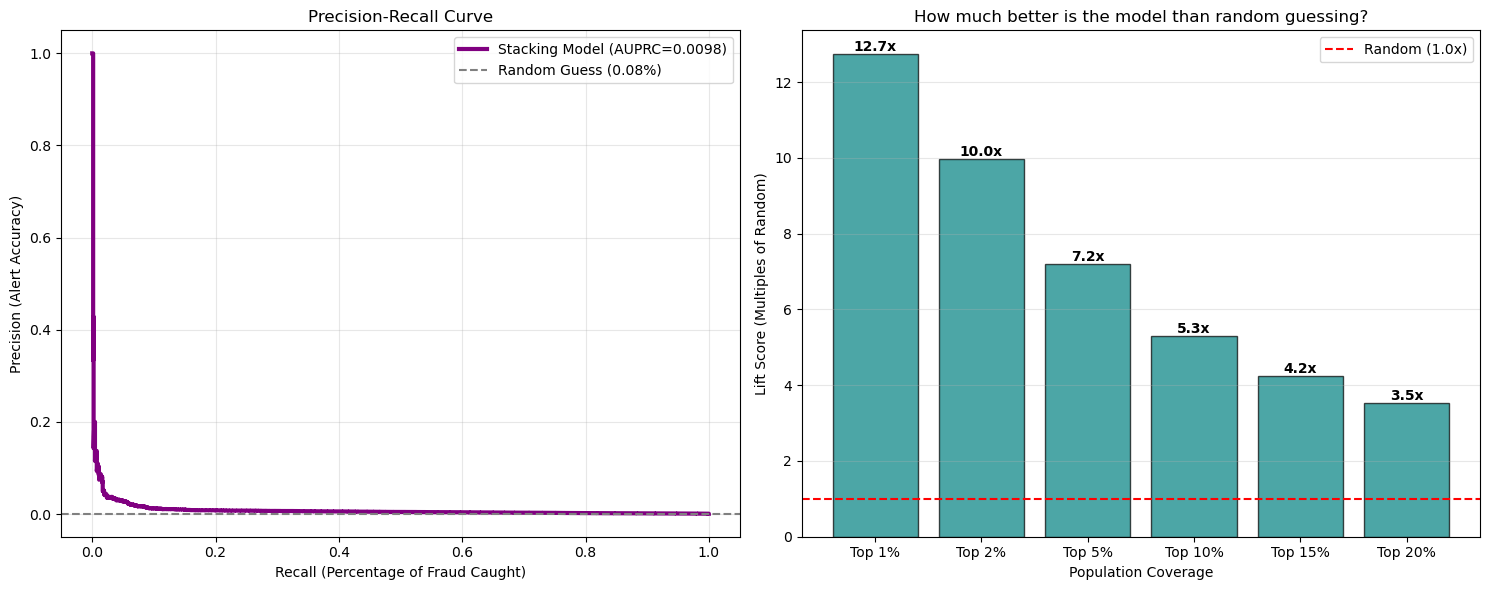


 FINAL VERDICT:
STRONG: Lift is 12.73x. This is definitely production-grade.


In [37]:
# --- FINAL PERFORMANCE REPORT & LIFT ANALYSIS ---
from sklearn.metrics import average_precision_score, precision_recall_curve

print("--- FINAL MODEL REPORT CARD (0-20% Coverage) ---")

# 1. Global Metrics
# Calculate Base Rate (Random Guessing Performance)
base_rate = y_val.mean()
auprc = average_precision_score(y_val, y_probs_stack)

print(f" Global AUPRC:      {auprc:.4f}")
print(f" Base Fraud Rate:   {base_rate:.4%} (1 in {int(1/base_rate)} txns is fraud)")

# 2. The "Business Value" Table (Metrics by Depth)
metrics_list = []
depths = [1, 2, 5, 10, 15, 20] # Analyze Top 1% to Top 20%

for d in depths:
    # Find threshold for Top d%
    thresh = np.percentile(y_probs_stack, 100 - d)
    
    # Make predictions
    y_pred = (y_probs_stack >= thresh).astype(int)
    
    # Calculate Stats
    n_alerts = y_pred.sum()
    n_fraud_caught = (y_pred * y_val).sum()
    
    precision = n_fraud_caught / n_alerts if n_alerts > 0 else 0
    recall = n_fraud_caught / y_val.sum()
    
    # LIFT = How many times better than random?
    lift = precision / base_rate
    
    metrics_list.append({
        'Coverage': f"Top {d}%",
        'Threshold': f"{thresh:.4f}",
        'Fraud Caught': f"{n_fraud_caught:,.0f}",
        'Recall': f"{recall:.2%}",
        'Precision': f"{precision:.2%}",
        'LIFT SCORE': f"{lift:.2f}x "
    })

# Create & Print Table
df_metrics = pd.DataFrame(metrics_list)
print("\n Detailed Performance at Different Risk Levels:")
print(df_metrics.to_string(index=False))

# 3. Visualization
plt.figure(figsize=(15, 6))

# Chart A: Precision-Recall Curve (Scientific View)
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_probs_stack)
plt.subplot(1, 2, 1)
plt.plot(recall_curve, precision_curve, label=f'Stacking Model (AUPRC={auprc:.4f})', color='purple', lw=3)
plt.axhline(y=base_rate, color='gray', linestyle='--', label=f'Random Guess ({base_rate:.2%})')
plt.xlabel('Recall (Percentage of Fraud Caught)')
plt.ylabel('Precision (Alert Accuracy)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Chart B: Lift by Depth (Business View)
# Extract numeric lift for plotting
lift_values = [float(x['LIFT SCORE'].split('x')[0]) for x in metrics_list]
labels = [x['Coverage'] for x in metrics_list]

plt.subplot(1, 2, 2)
bars = plt.bar(labels, lift_values, color='teal', alpha=0.7, edgecolor='black')

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}x',
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Population Coverage')
plt.ylabel('Lift Score (Multiples of Random)')
plt.title('How much better is the model than random guessing?')
plt.axhline(y=1, color='red', linestyle='--', label='Random (1.0x)')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Final Verdict Text
top1_lift = float(metrics_list[0]['LIFT SCORE'].split('x')[0])
print("\n FINAL VERDICT:")
if top1_lift > 15:
    print(f"PHENOMENAL: At 1% volume, you are catching fraud {top1_lift}x better than random.")
    print("   This is a highly deployable model.")
elif top1_lift > 5:
    print(f"STRONG: Lift is {top1_lift}x. This is definitely production-grade.")
else:
    print(f" WEAK: Lift is only {top1_lift}x. Re-check the Autoencoder/Scaling.")

In [39]:
import joblib
import json
import shutil
import os
import numpy as np

print("--- PACKAGING FINAL FRAUD PIPELINE ---")

# 1. Create Directory
model_dir = 'fraud_pipeline_v2'
os.makedirs(model_dir, exist_ok=True)

# 2. Define Artifacts to Save (Sklearn/XGBoost)
# We check if they exist in memory first to avoid errors
artifacts = {
    "scaler.pkl": scaler if 'scaler' in locals() else None,
    "pca_model.pkl": pca if 'pca' in locals() else None,
    "kmeans_model.pkl": kmeans if 'kmeans' in locals() else None,
    "isolation_forest.pkl": iso_forest if 'iso_forest' in locals() else None,
    "xgboost_champion.pkl": clf_champion if 'clf_champion' in locals() else None
}

print("\n Saving Standard Models...")
for filename, model in artifacts.items():
    if model is not None:
        try:
            joblib.dump(model, os.path.join(model_dir, filename))
            print(f"    Saved {filename}")
        except Exception as e:
            print(f"    Error saving {filename}: {e}")
    else:
        print(f"    Skipping {filename} (Not found in memory)")

# 3. Save Keras Autoencoder (Special Handling)
if 'autoencoder' in locals():
    try:
        autoencoder.save(os.path.join(model_dir, "autoencoder.keras"))
        print("    Saved autoencoder.keras")
    except Exception as e:
        print(f"    Error saving Autoencoder: {e}")

# 4. Generate Master Configuration
# This file tells the API exactly how to transform data.
if 'X_train' in locals():
    raw_features = list(X_train.columns) if hasattr(X_train, 'columns') else []
    # If X_train already has enriched features, we need the ORIGINAL raw columns too.
    # Assuming the first 18-19 columns are raw. Adjust logic if needed.
else:
    raw_features = "Unknown (Check your notebook)"

config = {
    "meta": {
        "name": "FraudGuard_Deep_XGBoost",
        "version": "2.0",
        "author": "User"
    },
    "pipeline_steps": {
        "1_scaling": "StandardScaler (Apply to all numeric inputs)",
        "2_autoencoder": "Calculate Reconstruction Error (MSE)",
        "3_pca": "Calculate Reconstruction Error",
        "4_kmeans": "Calculate Distance to Nearest Cluster",
        "5_iso_forest": "Calculate Anomaly Score",
        "6_classifier": "XGBoost Probability"
    },
    "input_schema": {
        "raw_features_expected": raw_features, # The columns the API expects
        "final_model_features": clf_champion.get_booster().feature_names if 'clf_champion' in locals() else []
    },
    "thresholds": {
        "high_risk_cutoff": float(np.percentile(y_probs_stack, 99)) if 'y_probs_stack' in locals() else 0.90,
        "medium_risk_cutoff": float(np.percentile(y_probs_stack, 95)) if 'y_probs_stack' in locals() else 0.50,
        "base_fraud_rate": float(y_val.mean()) if 'y_val' in locals() else 0.001
    }
}

# Save Config
with open(os.path.join(model_dir, 'pipeline_config.json'), 'w') as f:
    json.dump(config, f, indent=4)
print("    Saved pipeline_config.json")

# 5. Zip it up
shutil.make_archive(model_dir, 'zip', model_dir)
print(f"\nSUCCESS! Download '{model_dir}.zip'.")

--- PACKAGING FINAL FRAUD PIPELINE ---

 Saving Standard Models...
    Saved scaler.pkl
    Saved pca_model.pkl
    Saved kmeans_model.pkl
    Saved isolation_forest.pkl
    Saved xgboost_champion.pkl
    Saved autoencoder.keras
    Saved pipeline_config.json

SUCCESS! Download 'fraud_pipeline_v2.zip'.
